In [1]:
#The API key used for getting datas 
api_key="ILVSJ4QHOJL3WBG4"

In [2]:
#Importing the required modules and libraries
from alpha_vantage.foreignexchange import ForeignExchange
from pprint import pprint
import numpy as np
import pandas as pd
cc = ForeignExchange(key=api_key)
data0, _ = cc.get_currency_exchange_daily("USD", 'EUR',"pandas")

In [3]:
#The transpose of the data is taken to see the date as a row and data is reversed to see 
#nearest day in the last row.
df2 = pd.DataFrame(data0).T.iloc[::-1]
#the name of the features are added in a list.
featurecolumns =["MA6", "MA12", "MA24", "MA72","MA144", "Previous Day"]
#a data frame is created using above list
featureframe = pd.DataFrame(data = None, columns = featurecolumns)


In [4]:
#the moving average calculations are done below
featureframe['MA6'] = df2.rolling(6).sum()["4. close"]/6
featureframe['MA12'] = df2.rolling(12).sum()["4. close"]/12
featureframe['MA24'] = df2.rolling(24).sum()["4. close"]/24
featureframe['MA72'] = df2.rolling(72).sum()["4. close"]/72
featureframe['MA144'] = df2.rolling(144).sum()["4. close"]/144
#previous day column is equalized to close rates
featureframe["Previous Day"] = df2["4. close"]
#then the frame is shifted to make it a feature for the next day
featureframe = featureframe.shift(1)
featureframe


,MA6,MA12,MA24,MA72,MA144,Previous Day
2014-11-07,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-09,NaN,NaN,NaN,NaN,NaN,0.8025
2014-11-10,NaN,NaN,NaN,NaN,NaN,0.8021
2014-11-11,NaN,NaN,NaN,NaN,NaN,0.8046
2014-11-12,NaN,NaN,NaN,NaN,NaN,0.8015
2014-11-13,NaN,NaN,NaN,NaN,NaN,0.8044
2014-11-14,0.802733,NaN,NaN,NaN,NaN,0.8013
2014-11-15,0.802017,NaN,NaN,NaN,NaN,0.7982
2014-11-16,0.801367,NaN,NaN,NaN,NaN,0.7982
2014-11-17,0.800367,NaN,NaN,NaN,NaN,0.7986


In [5]:


#closing rate is added as the last column as a label
featureframe["Closing Rate"] = df2["4. close"]
#empty rows are dropped
featureframe = featureframe.dropna()

In [6]:
featureframe

,MA6,MA12,MA24,MA72,MA144,Previous Day,Closing Rate
2015-04-13,0.931117,0.925683,0.925025,0.905181,0.863051,0.9420,0.9456
2015-04-14,0.936317,0.927567,0.925012,0.905860,0.864045,0.9456,0.9387
2015-04-15,0.938833,0.928217,0.924804,0.906540,0.864994,0.9387,0.9364
2015-04-16,0.940400,0.928892,0.925350,0.907336,0.865909,0.9364,0.9290
2015-04-17,0.938983,0.929708,0.925012,0.907925,0.866794,0.9290,0.9250
2015-04-19,0.936117,0.930825,0.925037,0.908514,0.867632,0.9250,0.9261
2015-04-20,0.933467,0.932292,0.925192,0.909075,0.868499,0.9261,0.9310
2015-04-21,0.931033,0.933675,0.925975,0.909733,0.869421,0.9310,0.9311
2015-04-22,0.929767,0.934300,0.926596,0.910418,0.870344,0.9311,0.9326
2015-04-23,0.929133,0.934767,0.927462,0.911260,0.871274,0.9326,0.9244


In [7]:
# Remaining are the plots and graphs......



#last day is excluded because it's close rate is not known yet
featureframe = featureframe.drop(featureframe.index[len(featureframe)-1])

In [8]:
featureframe

,MA6,MA12,MA24,MA72,MA144,Previous Day,Closing Rate
2015-04-13,0.931117,0.925683,0.925025,0.905181,0.863051,0.9420,0.9456
2015-04-14,0.936317,0.927567,0.925012,0.905860,0.864045,0.9456,0.9387
2015-04-15,0.938833,0.928217,0.924804,0.906540,0.864994,0.9387,0.9364
2015-04-16,0.940400,0.928892,0.925350,0.907336,0.865909,0.9364,0.9290
2015-04-17,0.938983,0.929708,0.925012,0.907925,0.866794,0.9290,0.9250
2015-04-19,0.936117,0.930825,0.925037,0.908514,0.867632,0.9250,0.9261
2015-04-20,0.933467,0.932292,0.925192,0.909075,0.868499,0.9261,0.9310
2015-04-21,0.931033,0.933675,0.925975,0.909733,0.869421,0.9310,0.9311
2015-04-22,0.929767,0.934300,0.926596,0.910418,0.870344,0.9311,0.9326
2015-04-23,0.929133,0.934767,0.927462,0.911260,0.871274,0.9326,0.9244


In [9]:
#test split method is imported for splitting the data
from sklearn.model_selection import train_test_split
#data is split
Xtrain, Xtest, ytrain, ytest = train_test_split(featureframe[featurecolumns], featureframe["Closing Rate"], test_size = 0.9)

In [10]:
#svm is imported
import sklearn.svm as svm
#Epsilon values are taken in a list for validation
Qs = np.array([1e-6, 1e-5,1e-4,1e-3,1e-2,1e-1])
#Cost values are taken in a list for validation
Cs = np.array([1e-3, 1e-2, 1e-1, 1e-0, 50, 100, 200])
TotalEins= []
TotalEvals=[]
TotalEval = 0

#the outer loop is to iterate the epsilon values
for j, Q in enumerate(Qs):
    #mid loop is to iterate cost values
    for i, C in enumerate(Cs):
        #the inner loop is for cross validation 
        for k in range(int(ytrain.size/10)):
            #validation set and train set are split using 10-fold method
            validtestf = Xtrain[(k*10):(k+1)*10]
            validtestl = ytrain[(k*10):(k+1)*10]
            validtrainf = np.delete(Xtrain.values, np.s_[(k*10):(k+1)*10],0)
            validtrainl = np.delete(ytrain.values, np.s_[(k*10):(k+1)*10],0)
            #model is created with iterated values
            prob = svm.SVR(kernel="linear",C = C, epsilon=Q)
            #trained with the training set for validation
            m = prob.fit(validtrainf, validtrainl)
            #resutls of the predict method
            p_valtest = prob.predict(validtestf)
            counter = 0
            E_val = 0
            #this loop calculates error for a sample
            for x, y in np.nditer([p_valtest, validtestl.values],["refs_ok"]):
                E_val  = float(x) - float(y)
                E_val = E_val**2
                counter +=1
            E_val = E_val/counter
            TotalEval += E_val
        #validation error of given parameters
        TotalEval=TotalEval/int(ytrain.size/10)
        #it is appended to a list to keep
        TotalEvals.append(TotalEval)
        TotalEval = 0




In [11]:
print(TotalEvals.index(min(TotalEvals)))
counter = 0
BestQ = 0
BestC = 0
#the best parameter is printed
for j, Q in enumerate(Qs):
    for i, C in enumerate(Cs):
        if TotalEvals.index(min(TotalEvals)) == counter:
            BestQ = Q
            BestC = C
            print("|||THIS ONE BELOW:|||")
        print("Epsilon = %lf, C = %.3lf , Ecval = %.20e" % (Q, C, TotalEvals[counter]))
        counter += 1

34
Epsilon = 0.000001, C = 0.001 , Ecval = 2.28701186595825912799e-04
Epsilon = 0.000001, C = 0.010 , Ecval = 1.61182033491766112370e-04
Epsilon = 0.000001, C = 0.100 , Ecval = 1.15945750726407365017e-05
Epsilon = 0.000001, C = 1.000 , Ecval = 2.79605421768543266405e-06
Epsilon = 0.000001, C = 50.000 , Ecval = 1.82569429724913071512e-06
Epsilon = 0.000001, C = 100.000 , Ecval = 1.77793843298261415017e-06
Epsilon = 0.000001, C = 200.000 , Ecval = 1.66710419847342352305e-06
Epsilon = 0.000010, C = 0.001 , Ecval = 2.28701186595825912799e-04
Epsilon = 0.000010, C = 0.010 , Ecval = 1.61222329600474066028e-04
Epsilon = 0.000010, C = 0.100 , Ecval = 1.16794075216717708251e-05
Epsilon = 0.000010, C = 1.000 , Ecval = 2.72897944572537182572e-06
Epsilon = 0.000010, C = 50.000 , Ecval = 1.85268371477428029800e-06
Epsilon = 0.000010, C = 100.000 , Ecval = 1.73724949330720459174e-06
Epsilon = 0.000010, C = 200.000 , Ecval = 1.69696175922045355739e-06
Epsilon = 0.000100, C = 0.001 , Ecval = 2.2867534

In [12]:
#to plot the validation error 
import matplotlib.pyplot as plt
#parameters are put in arrays and they are plotted
epsilon = np.array(Qs)
Carray = np.array(Cs)
Evalarray = np.array(TotalEvals)
X, Y= np.meshgrid(epsilon, Carray)
Evalarray =np.reshape(Evalarray,(len(Carray),len(epsilon)))
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim3d(0, 1e-1)
ax.set_ylim3d(0,500)
ax.set_zlim3d(0,1.5*1e-4)
ax.set_xlabel('Epsilon', fontsize=23)
ax.set_ylabel('C', fontsize=23)
ax.set_zlabel('Validation Error', fontsize=23)
ax.scatter(X,Y,Evalarray, s = 80)



In [13]:

# In[9]:

#the model is trained with best parameters
problem = svm.SVR(kernel="linear",C = BestC, epsilon=BestQ)
problem.fit(Xtrain, ytrain)
#tested with the test set
p_test = problem.predict(Xtest)
counter = 0
E_test = 0
TestError= 0
#test error calculation
for x, y in np.nditer([p_test, ytest.astype("float")],["refs_ok"]):
    E_test  = float(x) - float(y)
    E_test = E_test**2
    counter +=1
E_test = E_test/counter
print(E_test/ytest.astype("float").std()**2)
print(E_test)


1.0066266178676275e-07
1.3577012753200952e-10


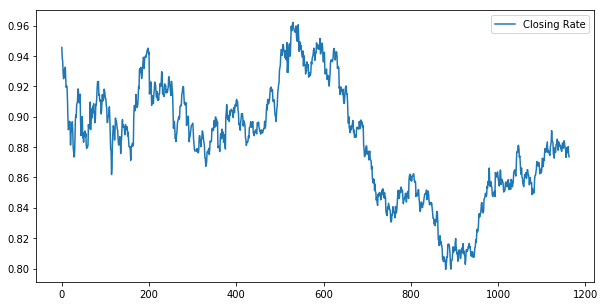

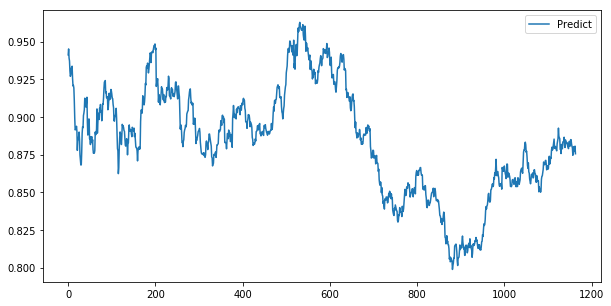

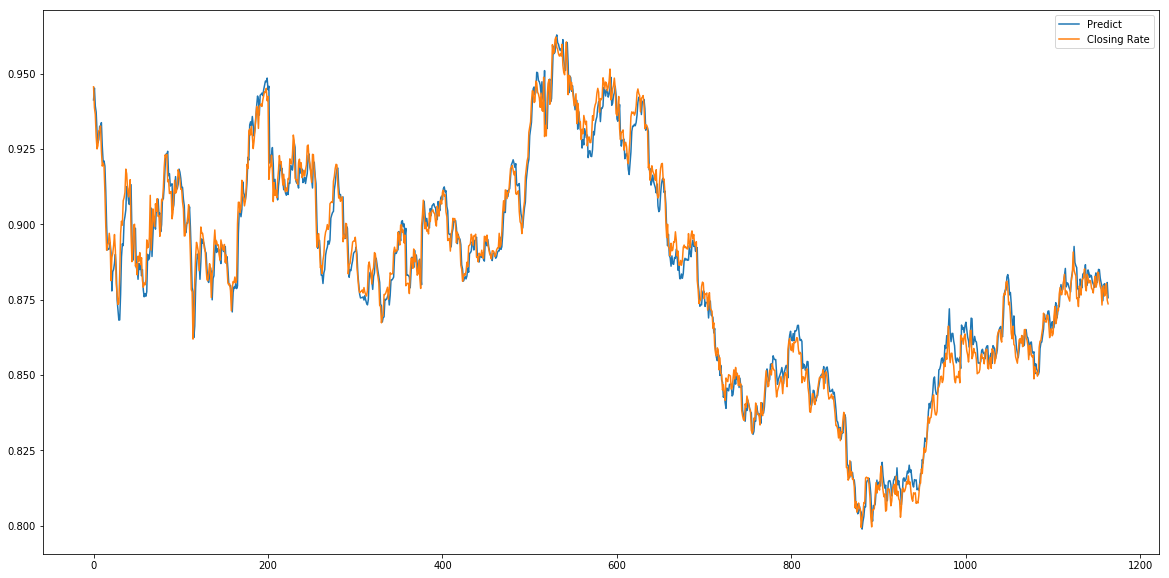

In [14]:


# In[10]:

#predicting the whole dataset
deneme = problem.predict(featureframe[featurecolumns])



# In[11]:

#plotting the output with the real value

plotframe = featureframe["Closing Rate"].values.astype("float")
plotframe = pd.DataFrame(plotframe, columns=["Closing Rate"])
plotframe2 = pd.DataFrame(deneme,columns=["Predict"])
plotframe.plot(figsize=(10,5))
plotframe2.plot(figsize=(10,5))
plotframe2["Closing Rate"] = plotframe.values
plotframe2.plot(figsize=(20,10))


In [15]:
today = featureframe.iloc[len(featureframe)-1].values
a = today.reshape(1,-1)
a = a[:,:a.shape[1]-1]
problem.predict(a)

array([0.8756284])

In [16]:
featureframe["Prediction"] = deneme
featureframe

,MA6,MA12,MA24,MA72,MA144,Previous Day,Closing Rate,Prediction
2015-04-13,0.931117,0.925683,0.925025,0.905181,0.863051,0.9420,0.9456,0.941250
2015-04-14,0.936317,0.927567,0.925012,0.905860,0.864045,0.9456,0.9387,0.945188
2015-04-15,0.938833,0.928217,0.924804,0.906540,0.864994,0.9387,0.9364,0.939205
2015-04-16,0.940400,0.928892,0.925350,0.907336,0.865909,0.9364,0.9290,0.937221
2015-04-17,0.938983,0.929708,0.925012,0.907925,0.866794,0.9290,0.9250,0.930604
2015-04-19,0.936117,0.930825,0.925037,0.908514,0.867632,0.9250,0.9261,0.926997
2015-04-20,0.933467,0.932292,0.925192,0.909075,0.868499,0.9261,0.9310,0.928081
2015-04-21,0.931033,0.933675,0.925975,0.909733,0.869421,0.9310,0.9311,0.932507
2015-04-22,0.929767,0.934300,0.926596,0.910418,0.870344,0.9311,0.9326,0.932507
2015-04-23,0.929133,0.934767,0.927462,0.911260,0.871274,0.9326,0.9244,0.933719
